# GNN training for SIS dynamics on a BA network

## Including relevant packages

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import dynalearn as dl
import tqdm
from scipy.spatial.distance import jensenshannon
import tensorflow as tf
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import os
import getpass
from matplotlib.lines import Line2D





## Parameters and hyperparameters

In [2]:
path_to_dir = "/home/" + getpass.getuser() + "/Documents/ulaval/doctorat/projects/dynalearn/data/training/"
if os.path.exists("media/" + getpass.getuser() + "LaCie/"):
    path_to_dir = "media/" + getpass.getuser() + "LaCie/dynalearn-data/training/"
    
    

param_dict = {
    "name": "sis_ba_0",
    "graph": {"name": "BAGraph", "params": {"N": 1000, "M": 2}},
    "dynamics": {
        "name": "SIS",
        "params": {"infection_prob": 0.04, "recovery_prob": 0.08, "init_state": "None"},
    },
    "model": {
        "name": "LocalStatePredictor",
        "params": {
            "in_features": [32],
            "attn_features": [32],
            "out_features": [32],
            "n_heads": [1],
            "in_activation": "relu",
            "attn_activation": "relu",
            "out_activation": "relu",
            "weight_decay": 0.0001,
            "tf_seed": 2,
        },
    },
    "generator": {
        "name": "DynamicsGenerator",
        "params": {
            "batch_size": -1,
            "num_graphs": 1,
            "num_sample": 100,
            "resampling_time": 2,
            "val_fraction": 0.01,
            "max_null_iter": 1,
            "with_truth": 0,
        },
        "sampler": {
            "name": "StateBiasedSampler",
            "params": {
                "sampling_bias": 0.6,
                "val_bias": 0.8,
                "replace": 1,
                "resample": 100,
                "sample_from_weights": 0,
            },
        },
    },
    "config": {
        "optimizer": "Adam",
        "initial_lr": 0.0005,
        "loss": "categorical_crossentropy",
        "schedule": {"epoch": 10, "factor": 2},
        "epochs": 20,
        "np_seed": 1,
    },
    "metrics": [
        "AttentionMetrics",
        "TrueLTPMetrics",
        "GNNLTPMetrics",
        "MLELTPMetrics",
        "TrueStarLTPMetrics",
        "GNNStarLTPMetrics",
        "StatisticsMetrics",
    ],
    "path_to_dir": path_to_dir,
    "filename_data": "data.h5",
    "filename_metrics": "metrics.h5",
    "filename_model": "model.h5",
    "filename_bestmodel": "bestmodel.h5",
}

## Loading the experiment settings

In [3]:
experiment = dl.Experiment(param_dict)

## Generating the training and validation datasets

In [4]:
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_data)):
    experiment.load_data()
else:
    experiment.generate_data()
    experiment.save_data()


Generating data - 0.02555s: 100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


Partitioning generator for validation


## Training the GNN model

In [5]:
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_model)):
    experiment.load_model()
else:
    experiment.train_model()
    experiment.save_model()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 1/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.6345 - model_entropy: 0.6809
Epoch 00001: val_loss improved from inf to 0.53554, saving model to /home/charles_murphy/Documents/ulaval/doctorat/projects/dynalearn/data/training/sis_ba_0/bestmodel.h5
100/100 [==============================] - 2s 23ms/step - loss: 0.6348 - model_entropy: 0.6806 - val_loss: 0.5355 - val_model_entropy: 0.6757

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 2/20
 97/100 [============================>.] - ETA: 0s - loss: 0.5926 - model_entropy: 0.6742
Epoch 00002: val_loss improved from 0.53554 to 0.50020, saving model to /home/charles_murphy/Documents/ulaval/doctorat/projects/dynalearn/data/training/sis_ba_0/bestmodel.h5
100/100 [==============================] - 2s 16ms/step - loss: 0.5879 - model_entropy: 0.6736 - val_loss: 0.5002 - val_model_entropy: 0.6712


 98/100 [============================>.] - ETA: 0s - loss: 0.2964 - model_entropy: 0.3137
Epoch 00020: val_loss did not improve from 0.35548
100/100 [==============================] - 2s 15ms/step - loss: 0.2979 - model_entropy: 0.3138 - val_loss: 0.3567 - val_model_entropy: 0.3082


## Computing the metrics post training

In [6]:
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_metrics)):
    experiment.load_metric()
else:
    experiment.compute_metrics()
    experiment.save_metrics()

Computing StatisticsMetrics: 100%|██████████| 100/100 [00:02<00:00, 46.88it/s]


## Showing LTPs

/home/charles_murphy/Documents/ulaval/doctorat/projects/dynalearn/dynalearn/metrics/aggregator.py:32: RuntimeWarning: Mean of empty slice
  y[i] = op_val(values[index, out_state])
/home/charles_murphy/Documents/ulaval/doctorat/projects/dynalearn/dynalearn/metrics/aggregator.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice.
  op_err = lambda xx: np.sqrt(np.nanvar(xx))


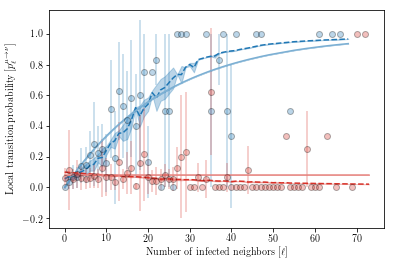

In [36]:
transitions = [(0, 1), (1, 0)]
transition_labels = [("S", "I"), ("I", "S")]

color_true = [dl.utilities.color_pale["blue"], dl.utilities.color_pale["red"]]
color_gnn = [dl.utilities.color_dark["blue"], dl.utilities.color_dark["red"]]
handles = []

for i, t in enumerate(transitions):
    x, y, err = experiment.metrics["MLELTPMetrics"].aggregate(in_state=t[0], out_state=t[1], dataset="train")
    plt.errorbar(x, y, yerr=err, linestyle='None', marker='o', color=color_gnn[i], alpha=0.3, 
                 markeredgewidth=1,
                 markeredgecolor='k')
    
    x, y, err = experiment.metrics["GNNLTPMetrics"].aggregate(in_state=t[0], out_state=t[1], dataset="val")
    plt.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    plt.plot(x, y, linestyle='--', color=color_gnn[i])
    
    x, y, err = experiment.metrics["TrueLTPMetrics"].aggregate(in_state=t[0], out_state=t[1], dataset="val")
    plt.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    plt.plot(x, y, linestyle='-', color=color_true[i])
    
plt.xlabel(r"Number of infected neighbors $[\ell]$")
plt.ylabel(r"Local transition probability $[p^{\mu\to\nu}_\ell]$")
plt.show()